# Thetis GPS Validation Notebook

In [98]:
# Imports and constants
from ctypes import sizeof
from util import ThetisData
import matplotlib.pyplot as plt
import datetime as dt
from math import pi
import numpy as np
from pyproj import Proj, Transformer
import math
from windrose import WindroseAxes, WindAxes

## Read in Thetis Data
The log file is created by appending a binary data structure continually to the end of the file. This data structure is defined in the `util.py` file and copies that found in the Thetis firmware. The telemetry log is refreshed at about 90 Hz, but the GPS data is only refreshed at 10 Hz. Therefore, to eliminate duplications, it is necessary to record every ninth sample. This will cause a couple of unique locations to potentially be lost, but over a long enough time span, this loss should be inconsequential.

We can see from the plot that there are several outliers in the data. These are most likely caused by imprecise measurements taken by the GPS when sampling at the maximum refresh rate of 10 Hz. These outliers may be mitigated by using the advertised sample rate of 1 Hz, however we will examine statistical elimination, for now.

N samples:  2290
[datetime.datetime(2022, 12, 12, 14, 4, 6, 70000)
 datetime.datetime(2022, 12, 12, 14, 4, 6, 163000)
 datetime.datetime(2022, 12, 12, 14, 4, 6, 266000) ...
 datetime.datetime(2022, 12, 12, 14, 7, 3, 292000)
 datetime.datetime(2022, 12, 12, 14, 7, 3, 369000)
 datetime.datetime(2022, 12, 12, 14, 7, 3, 459000)]
Samples removed for bad Lat/Lon data:  7
Samples removed for no GPS fix:  0
Samples removed for bad HDOP:  51185


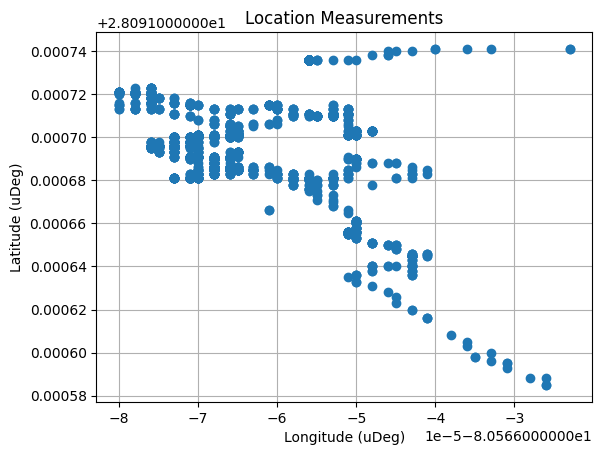

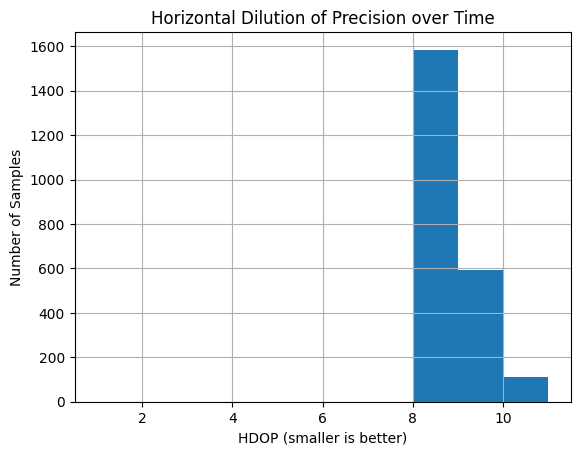

In [103]:
i = 0
latlon_remove_count = 0
no_gps_remove_count = 0
bad_hdop_remove_count = 0

with open('data/GPS_Test_Indialantic_10Hz.bin', 'rb') as file:
    epoch_data = []
    lat_data = []
    lon_data = []
    fix_data = []
    hdop_data = []

    data = ThetisData()
    while file.readinto(data) == sizeof(data):
        i = i+1
        if (i % 9 != 0): # Only return every [Sample Rate/ GPS Refresh Rate] value
            continue
        timestamp = dt.datetime.utcfromtimestamp(data.epoch) + dt.timedelta(milliseconds=data.mSecond)
        if (data.latitude==0 or data.longitude==0):
            latlon_remove_count = latlon_remove_count+1
            continue
        if (not data.GPSFix):
            no_gps_remove_count = no_gps_remove_count+1
            continue
        if (data.HDOP > 10):
            bad_hdop_remove_count = bad_hdop_remove_count+1
            continue
        epoch_data.append(timestamp)
        lat_data.append(data.latitude / 1E6)
        lon_data.append(data.longitude / 1E6)
        fix_data.append(data.GPSFix)
        hdop_data.append(data.HDOP)

    epoch_data = np.array(epoch_data)
    lat_data = np.array(lat_data)
    lon_data = np.array(lon_data)
    fix_data = np.array(fix_data)
    hdop_data = np.array(hdop_data)

    print("N samples: ", np.size(lat_data))
    print(epoch_data)
    # print(lat_data)
    # print(lon_data)

print("Samples removed for bad Lat/Lon data: ", latlon_remove_count)
print("Samples removed for no GPS fix: ", no_gps_remove_count)
print("Samples removed for bad HDOP: ", bad_hdop_remove_count)

loc_fig = plt.figure()
loc_ax = loc_fig.add_subplot(1,1,1)
loc_ax.plot(lon_data, lat_data, 'o')
loc_ax.grid()
loc_ax.set_xlabel("Longitude (uDeg)")
loc_ax.set_ylabel("Latitude (uDeg)")
loc_ax.set_title("Location Measurements")

hdop_fig = plt.figure()
hdop_ax = hdop_fig.add_subplot(1,1,1)
hdop_ax.hist(hdop_data, bins=np.arange(1,max(hdop_data)+2))
hdop_ax.grid()
hdop_ax.set_xlabel("HDOP (smaller is better)")
hdop_ax.set_ylabel("Number of Samples")
hdop_ax.set_title("Horizontal Dilution of Precision over Time")

plt.show()


## Calculate Delta X and Delta Y
Here, we convert the readings into UTM projection Northings and Eastings in meters, we will also determine the statistical parameters of the entire population

Based on 
- Harre, Ingo. "Calculation of Position Errors dRMS, 2dRMS, CEP95, and of the Error Ellipse for p=0.95". 2001, January.
- NovAtel. "GPS Position Accuracy Measures". 2003, December 03. APN-029 Rev 1.


[138.68472036 137.22532758 137.22532758 ...  51.01651745  51.01651745
  51.01651745]


<Figure size 640x480 with 0 Axes>

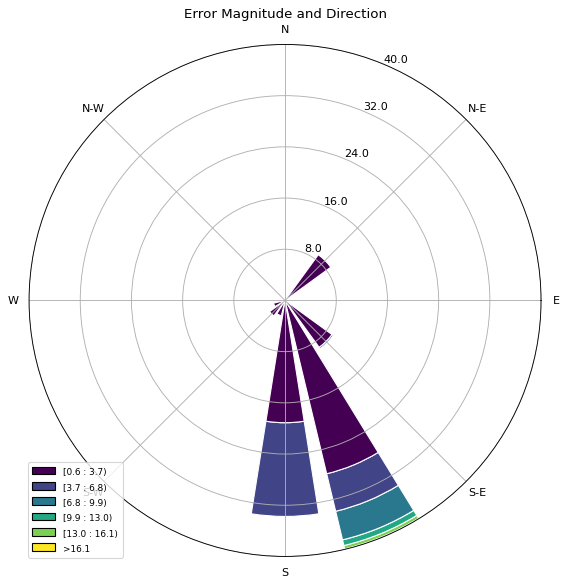

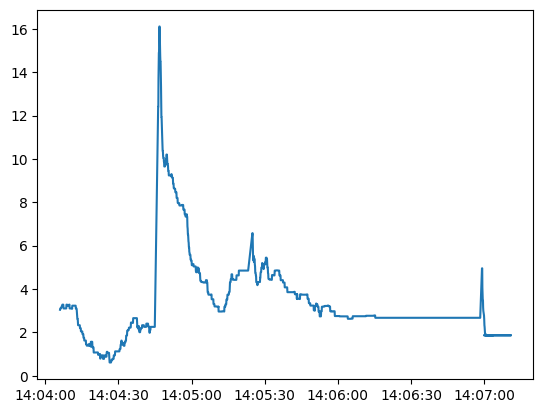

Sigma_x:  0.8593498333953875
Sigma_y:  2.3178993561008054
k:  0.37074510208285955
dRMS:  2.4720719166661005
2dRMS:  4.944143833332201
CEP:  1.9183335074839163


In [102]:
core = (28.091724647222, -80.56607002778) # Latitude and longitude of the US Geodetic Survey monument in Indialantic, FL, USA

# Calculate the delta in latitude and longitude between the measurements and the monument
delta_lat = lat_data - core[0]
delta_lon = lon_data - core[1]
# print(delta_lat)
# print(delta_lon)

# Convert the deltas to Northings and Eastings in meters, based on UTM projection
delta_y = 60 * 1852 * delta_lat
delta_x = 60 * 1852 * delta_lon * math.cos(math.pi/180 * core[0])
# print(delta_y)
# print(delta_y)

# Determine the error magnitudes for each Northing/Easting set relative to the monument
error_mag = np.sqrt(np.power(delta_y,2) + np.power(delta_x,2))
# print(error_mag)

# Determine the error bearing for each Northing/Easting set relative to the monument
error_bearing = np.arctan(delta_lat / delta_lon) * 180/math.pi
error_bearing[delta_lon > 0] = 90 - error_bearing[delta_lon > 0]
error_bearing[delta_lon < 0] = 270 - error_bearing[delta_lon < 0]
print(error_bearing)

# Plot the errors as a wind rose plot
error_fig = plt.figure()
error_ax = WindroseAxes.from_ax()
error_ax.bar(error_bearing, error_mag, normed=True, edgecolor='white')
error_ax.set_legend()
error_ax.set_title("Error Magnitude and Direction")

# Plot the deviation drift over time
# m = delta_y / delta_x
drift_fig = plt.figure()
drift_ax = drift_fig.add_subplot(1,1,1)
drift_ax.plot(epoch_data, error_mag)
plt.show()

# Calculate standard deviation in X
N_x = np.size(delta_x)
mu_x = np.mean(delta_x)
sigma_x = np.std(delta_x)
print("Sigma_x: ", sigma_x)

# Calculate standard deviation in Y
N_y = np.size(delta_y)
mu_y = np.mean(delta_y)
sigma_y = np.std(delta_y)
print("Sigma_y: ", sigma_y)

# Calculate eccentricity of error ellipse
sigma_arr = np.array([sigma_x, sigma_y])
k = min(sigma_arr) / max(sigma_arr)
print("k: ", k)

# Calculate dRMS
DRMS = math.sqrt(math.pow(sigma_x, 2) + math.pow(sigma_y, 2))
print("dRMS: ", DRMS)

# Calculate 2dRMS
TDRMS = 2 * DRMS
print("2dRMS: ", TDRMS)

# Calculate Circular Error Probability radius. Only valid when k > 0.3
CEP = 0.62*sigma_y + 0.56*sigma_x
print("CEP: ", CEP)

## Plot data
Plot the Northings and Eastings deviations from the monument. Also plots the Circular Error Probability and the 2dRMS circles

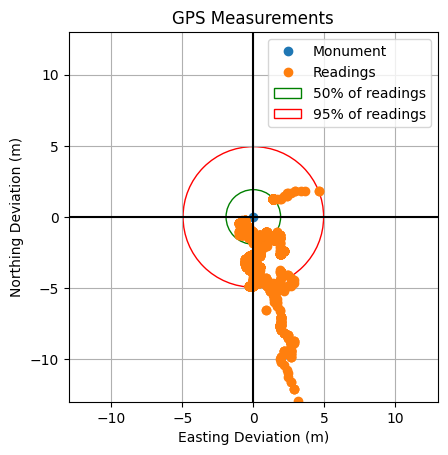

In [101]:
circle_cep = plt.Circle((0,0), radius=CEP, fill=False, color='green')
circle_tdrms = plt.Circle((0,0), radius=TDRMS, fill=False, color = 'red')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(0, 0, 'o')
ax.plot(delta_x, delta_y, 'o')
ax.set_xlim(left=-13, right=13)
ax.set_ylim(top=13, bottom=-13)
ax.add_patch(circle_cep)
ax.add_patch(circle_tdrms)
ax.grid()
ax.set_aspect('equal', adjustable='box')
ax.axvline(0,color='black')
ax.axhline(0,color='black')
ax.set_title("GPS Measurements")
ax.set_xlabel("Easting Deviation (m)")
ax.set_ylabel("Northing Deviation (m)")
ax.legend(["Monument", "Readings", "50% of readings", "95% of readings"])
plt.show()